In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-07-07 15:35:18.279432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-07 15:35:18.308501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 15:35:18.358110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 15:35:18.358264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4740337921968890874
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5955321856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3975139997307483271
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/test_withTips_1_07042022.hdf5', mode='r')
# h5 = h5py.File('./data/test_withTips_1_07042022.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])

print(f'Dataset shape is: {dataset.shape}')
train_dataset = np.take(dataset,train_index,axis=0)
val_dataset = np.take(dataset,val_index,axis=0)
print(f'Splitted trainning dataset shape is: {train_dataset.shape}')
print(f'Splitted trainning dataset shape is: {val_dataset.shape}')

Dataset shape is: (92, 69, 100, 100, 2)
Splitted trainning dataset shape is: (69, 69, 100, 100, 2)
Splitted trainning dataset shape is: (23, 69, 100, 100, 2)


In [3]:
from tqdm import tqdm

def create_shifted_frames_3to1(dataset):
    numFrames = 5

    for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
        for j in range(dataset.shape[1]-numFrames):
            currentFrame = np.expand_dims(np.expand_dims(np.expand_dims(dataset[i,j+numFrames,:,:,0],axis=0),axis=0),axis=4)
            pastFrames = np.expand_dims(np.expand_dims(dataset[i,j:(j+numFrames),:,:,0],axis=0),axis=4)
            try:
                x = np.append(x, pastFrames, axis=0)
                y = np.append(y, currentFrame, axis=0)
            except:
                x = pastFrames
                y = currentFrame
                
    return x,y

x_train, y_train = create_shifted_frames_3to1(train_dataset)
print(f'Training Dataset Shapes: {x_train.shape}, {y_train.shape}')
x_val, y_val = create_shifted_frames_3to1(val_dataset)
print(f'Validation Dataset Shapes: {x_val.shape}, {y_val.shape}')

Running ...: 100%|██████████| 69/69 [08:58<00:00,  7.81s/it]


Training Dataset Shapes: (4416, 5, 100, 100, 1), (4416, 1, 100, 100, 1)


Running ...: 100%|██████████| 23/23 [01:00<00:00,  2.62s/it]

Validation Dataset Shapes: (1472, 5, 100, 100, 1), (1472, 1, 100, 100, 1)


In [4]:
# np.save('./temp/test_withTips_1_07042022_x_train.npy',x_train)
# np.save('./temp/test_withTips_1_07042022_y_train.npy',y_train)
# np.save('./temp/test_withTips_1_07042022_x_val.npy',x_val)
# np.save('./temp/test_withTips_1_07042022_y_val.npy',y_val)

# x_train = np.load('./temp/test_withTips_1_07042022_x_train.npy')
# y_train = np.load('./temp/test_withTips_1_07042022_y_train.npy')
# x_val = np.load('./temp/test_withTips_1_07042022_x_val.npy')
# y_val = np.load('./temp/test_withTips_1_07042022_y_val.npy')

(4416, 5, 100, 100, 1)
2912


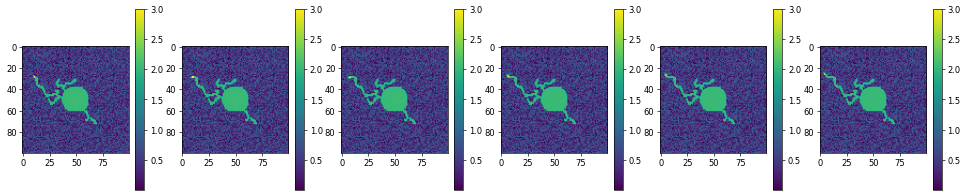

In [5]:
print(x_train.shape)
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
print(data_choice)
plt.figure(figsize=(20, 4), dpi=60)
plt.subplot(1,6,1)
plt.imshow(x_train[data_choice,0,:,:,0])
plt.colorbar()
plt.subplot(1,6,2)
plt.imshow(x_train[data_choice,1,:,:,0])
plt.colorbar()
plt.subplot(1,6,3)
plt.imshow(x_train[data_choice,2,:,:,0])
plt.colorbar()
plt.subplot(1,6,4)
plt.imshow(x_train[data_choice,3,:,:,0])
plt.colorbar()
plt.subplot(1,6,5)
plt.imshow(x_train[data_choice,4,:,:,0])
plt.colorbar()
plt.subplot(1,6,6)
plt.imshow(y_train[data_choice,0,:,:,0])
plt.colorbar()

In [6]:
from tensorflow.keras import layers
inp = layers.Input(shape=(x_train.shape[1:]))

# drop_rate = 0.1
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=False,
    activation="relu",
    # recurrent_dropout=drop_rate,
)(x1)
x2 = tf.expand_dims(x2,axis=1)
# x3 = layers.Concatenate(axis=4)([x1,x2])
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x2)
# ))(x3)
# x5 = layers.Concatenate(axis=4)([x0,x4])
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x4)
# ))(x5)
# x6 = layers.Dropout(drop_rate)(x6)

2022-07-07 15:45:27.521963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 15:45:27.522118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 15:45:27.522221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 15:45:27.522456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 15:45:27.522565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [7]:
# from tensorflow.keras import layers
# inp = layers.Input(shape=(x_train.shape[1:]))

# # drop_rate = 0.1
# x0 = layers.TimeDistributed(layers.Conv2D(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(inp)
# x1 = layers.TimeDistributed(layers.Conv2D(
#     filters=128,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x0)
# x2 = layers.ConvLSTM2D(
#     filters=128,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=False,
#     activation="relu",
#     # recurrent_dropout=drop_rate,
# )(x1)
# x3 = layers.Concatenate(axis=4)([tf.expand_dims(x1[:,-1,:,:,:],axis=1),tf.expand_dims(x2,axis=1)])
# x4 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=64,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x3)
# x5 = layers.Concatenate(axis=4)([tf.expand_dims(x0[:,-1,:,:,:],axis=1),x4])
# x6 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(x5)
# # x6 = layers.Dropout(drop_rate)(x6)

In [8]:
def get_deriv(input):
    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

def PINN_loss():
    def loss(y_true, y_pred):
        # need to figure the correct dt, and T_pre
        dt = 0.01*100
        # variables should be from inp ***** (INCORRECT AT THE MOMENT)
        tempr_pre = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        theta = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        NN_p = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        tub_pre = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)

        NN_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)

        # N1N_pK, NN1_pK, N2N_pK, N2N_pK, LAP_pK = get_deriv(NN_pK)
        N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        _, _, _, _, LAP_tp = get_deriv(tempr_pre)
        N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_pre)

        # Temperature calculation
        tempr = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_pre

        # Tubulin Equation
        diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_pre) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_pre) + tf.math.multiply(NN_p,NN1_tb))
        beta_tb = 0.001*tf.math.multiply(NN_p,tub_pre)
        src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        tub_K = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_pre

        # Energy calculation
        E = 0.2865*tf.math.atan(10*tf.math.multiply(5*tub_K-0.1,1-tempr))

        # phase field equation residual
        atheta = tf.math.atan2(NN1_p,N1N_p)
        a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        aap = tf.math.multiply(a,ap)
        a2 = tf.math.square(a)
        a2Lap = tf.math.multiply(a2,LAP_p)
        N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + E + 6*0.007*mag_theta)
        phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt
        
        residual = tf.math.reduce_mean(phi_residual)
        y_MSE = tf.math.reduce_mean(tf.square(tf.math.subtract(y_true[0,0,:,:,0], y_pred[0,0,:,:,0])))
        print(y_MSE)
        
        return y_MSE
    return loss

In [9]:
model = keras.models.Model(inp, x6)
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    # loss=PINN_loss(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-6))
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 100, 100, 1)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 5, 48, 48, 64)    1664      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 22, 22, 128)   204928    
 tributed)                                                       
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 22, 22, 128)       3277312   
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 22, 22, 128)   0         
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 48, 48, 64)    294976

In [10]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 2:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))

In [11]:
test = True

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test_3')
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 1000
    batch_size = 32
    saver = CustomSaver()

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            # callbacks=[saver,early_stopping, reduce_lr],
            callbacks=[early_stopping, reduce_lr],
        )
        # model.run_eagerly = True

    model.save('./saved_model/model_conv_lstm_test_3') 

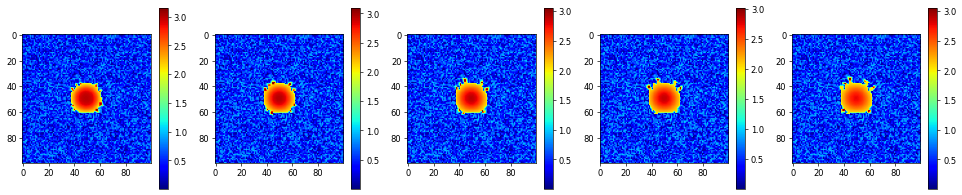

2022-07-07 15:45:35.560125: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-07-07 15:45:36.664671: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


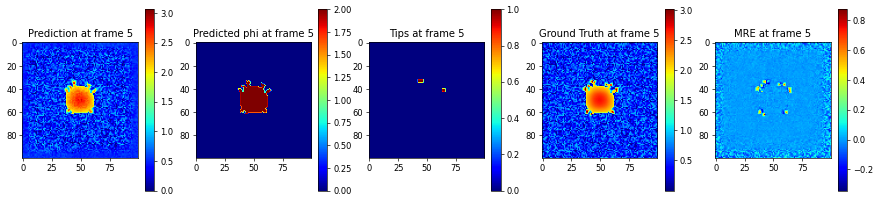

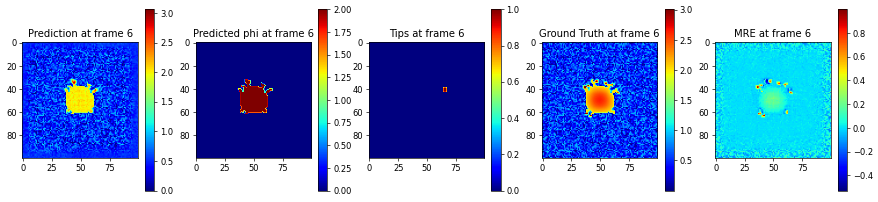

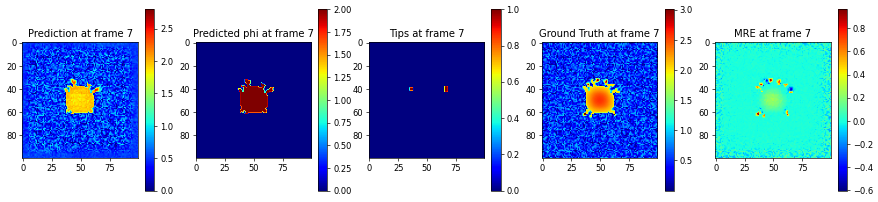

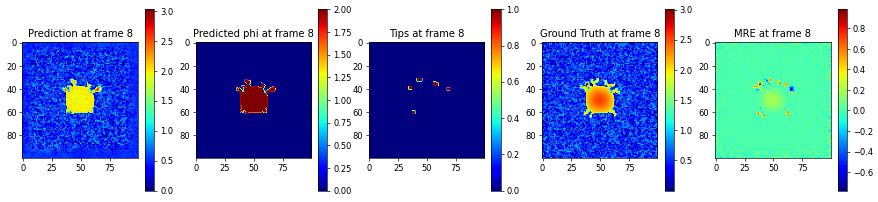

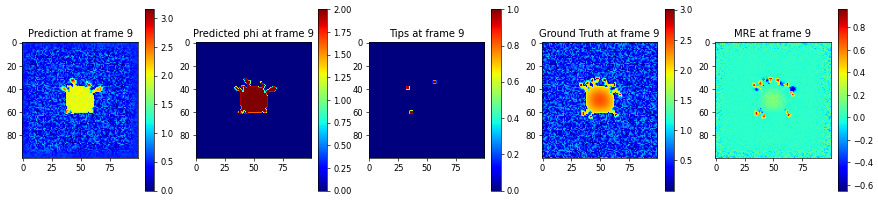

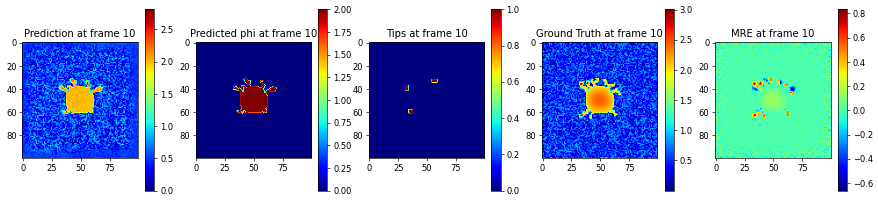

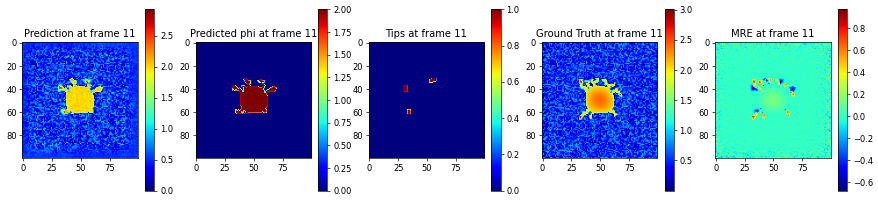

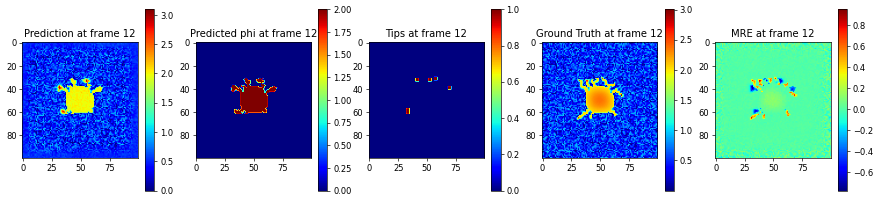

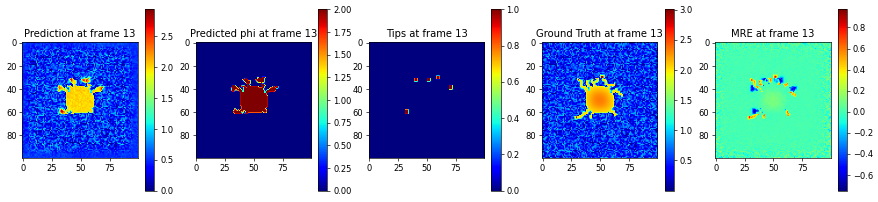

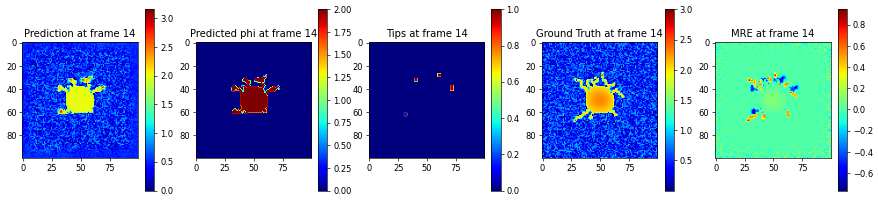

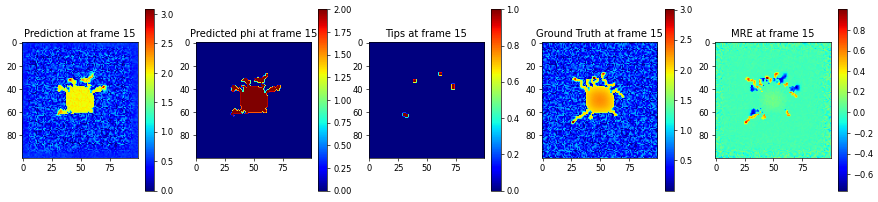

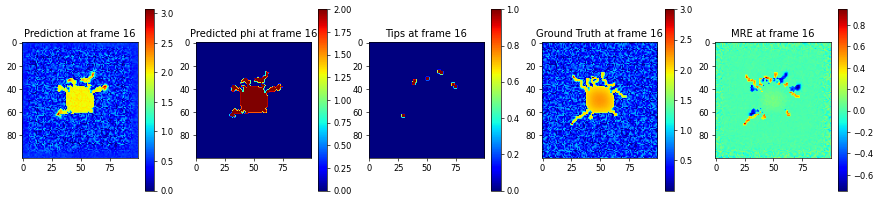

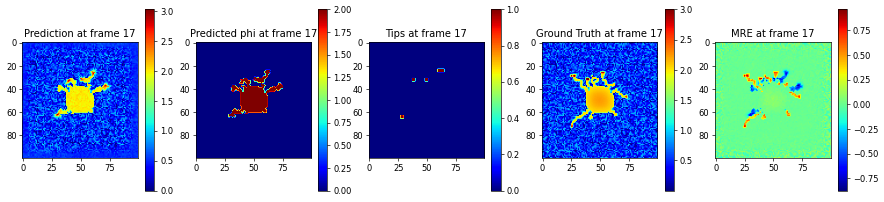

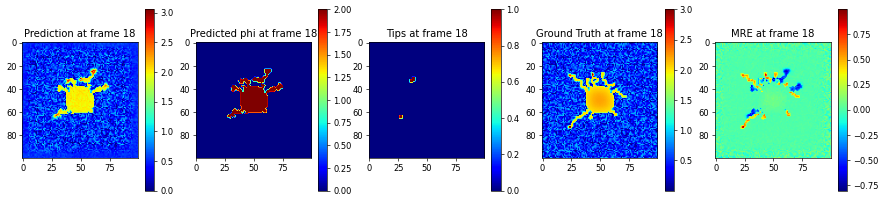

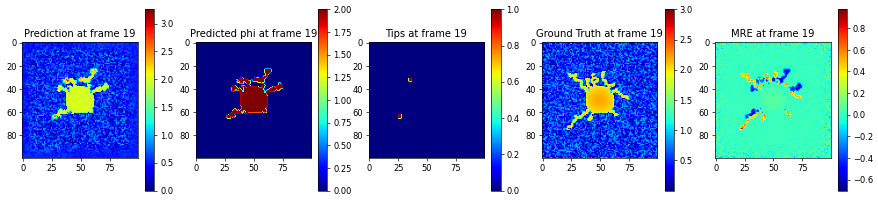

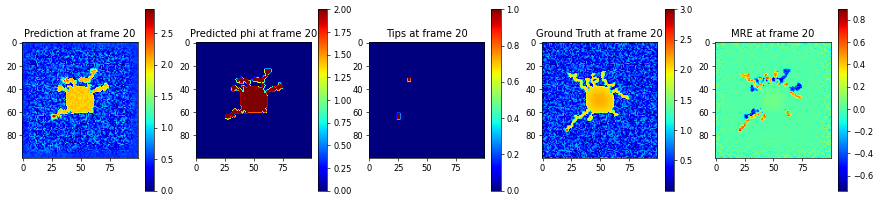

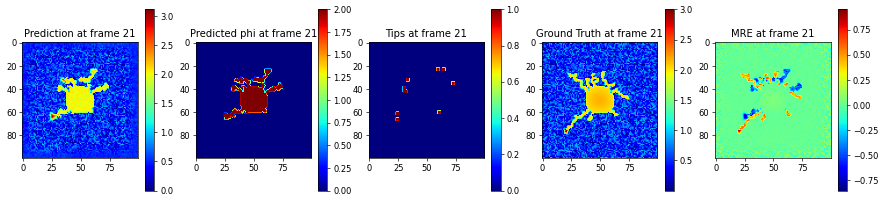

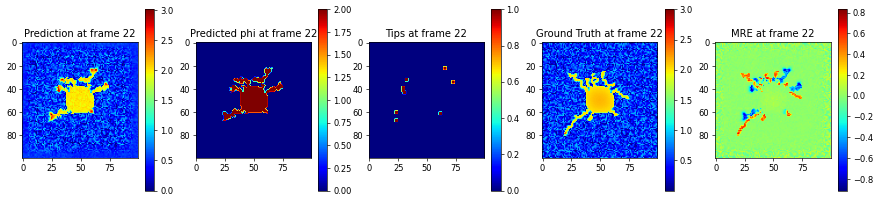

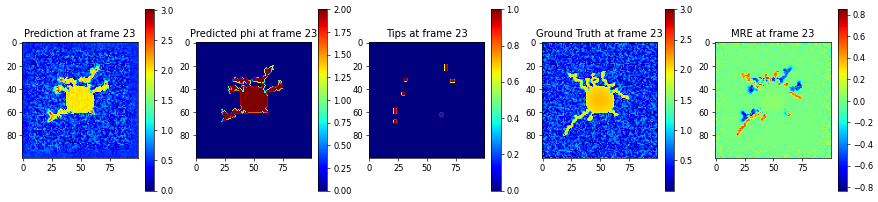

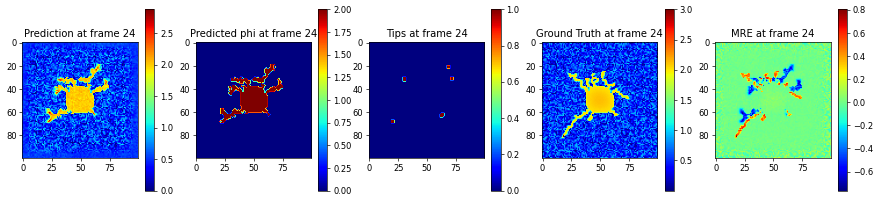

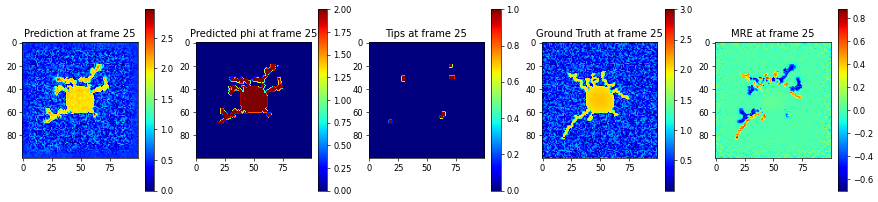

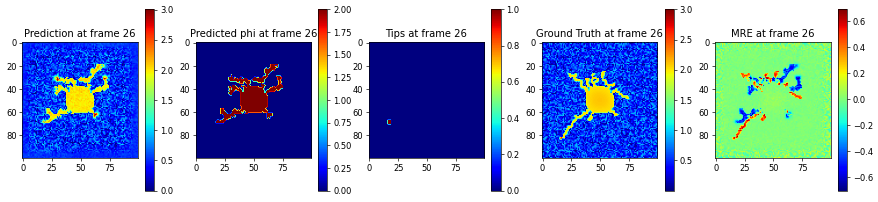

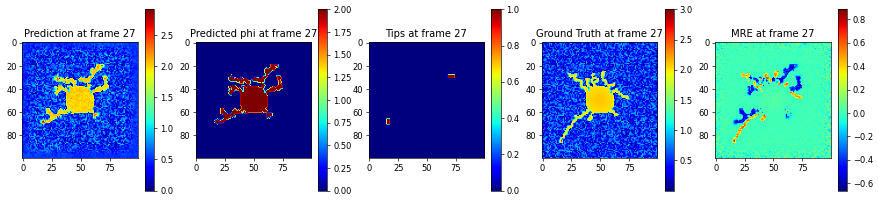

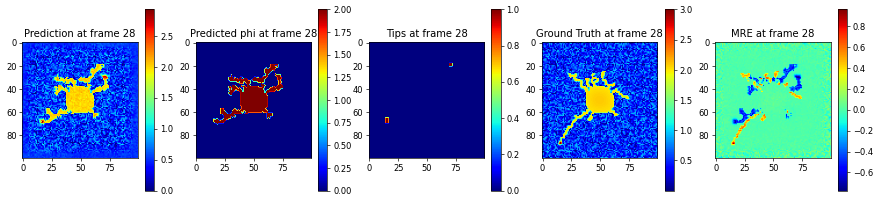

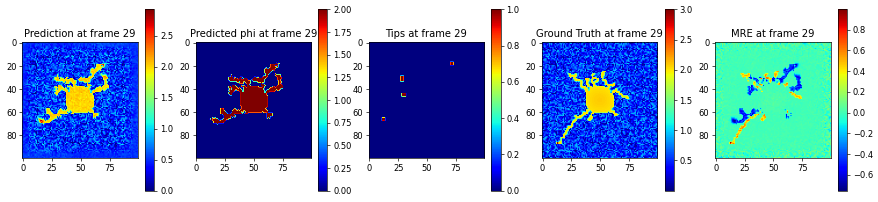

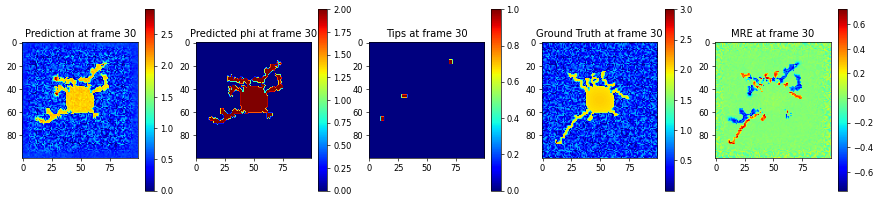

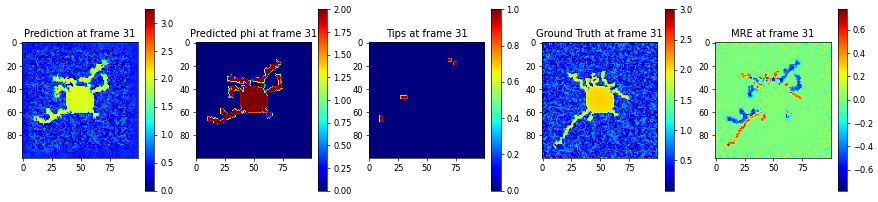

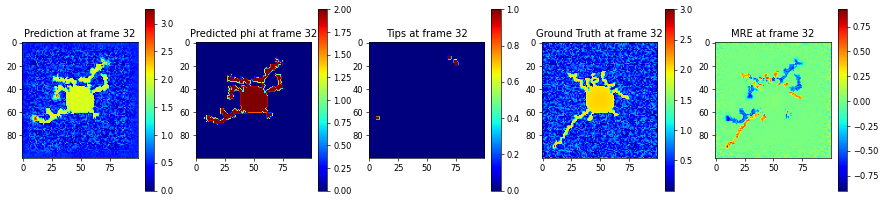

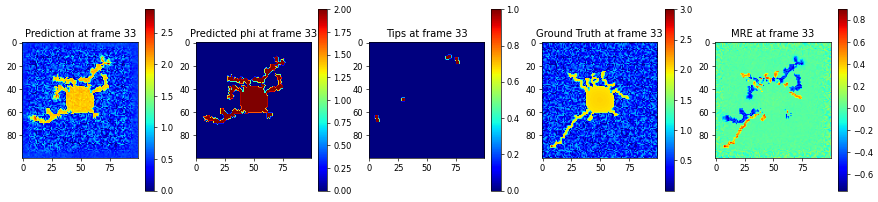

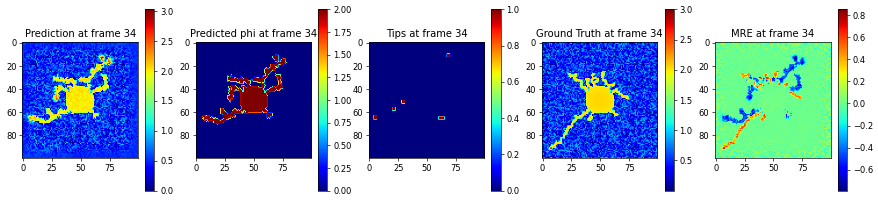

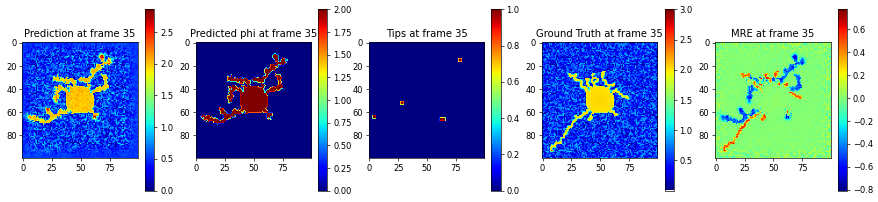

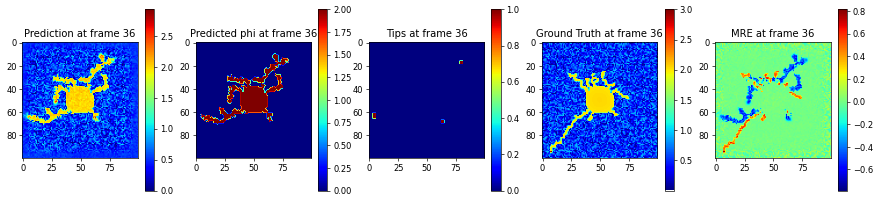

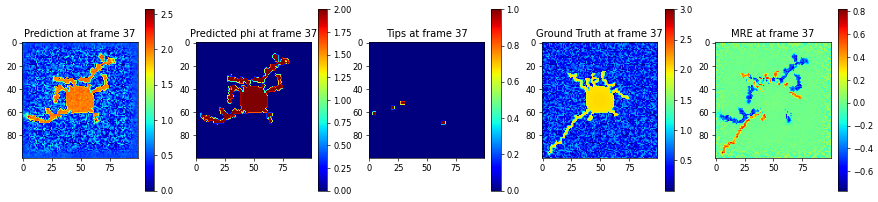

Index in position 1 is invalid. Array indices must be positive integers or
logical values.

Error in highlightZone (line 14)
                ttt(i,j) = 1;

Error in generate_tips_for_python (line 26)
    [theta_ori] = highlightZone(lenu,lenv,Max_x,Max_y,size_Max);



MatlabExecutionError: 
  File /home/kuanrenqian/Documents/NeuronGrowthML/tensorflow_version/highlightZone.m, line 14, in highlightZone

  File /home/kuanrenqian/Documents/NeuronGrowthML/tensorflow_version/generate_tips_for_python.m, line 26, in generate_tips_for_python
Index in position 1 is invalid. Array indices must be positive integers or logical values.


In [12]:
import matlab.engine
import copy
eng = matlab.engine.start_matlab()

def push(input, cutoff):
    max_input = np.amax(input)
    output = copy.copy(input)
    output[input>cutoff*max_input] = 1
    output[input<=cutoff*max_input] = 0
    return output
    
rand_case = np.random.randint((len(val_dataset)))
example_x = np.expand_dims(val_dataset[rand_case,:,:,:,0], axis=3)
example_theta = val_dataset[rand_case,0,:,:,1]
tmp_p_var = example_theta

plt.figure(figsize=(20, 4), dpi=60)
plt.subplot(1,5,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(1,5,2)
plt.imshow(example_x[1,:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(1,5,3)
plt.imshow(example_x[2,:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(1,5,4)
plt.imshow(example_x[3,:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(1,5,5)
plt.imshow(example_x[4,:,:,0], cmap='jet')
plt.colorbar()
plt.show()

x_in = np.expand_dims(example_x[0:5,...],axis=0)

for i in range(64):
    new_prediction = model.predict(x_in,verbose="0")
    # predicted_frame = np.expand_dims(new_prediction[0,0, ...], axis=0)
    p_var = new_prediction[0,0,:,:,0]

    # phi = push(p_var,0.45)
    phi = copy.copy(p_var)
    phi[phi>1.2] = 2
    phi[phi!=2] = 0
    
    tips_phi = copy.copy(phi)
    tips_phi[tips_phi!=2]=0
    tips_phi[tips_phi==2]=1
    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(tips_phi).astype('float64')),5000))

    plt.figure(figsize=(18, 4), dpi=60)
    plt.subplot(1,5,1)
    plt.imshow(p_var, cmap='jet')
    plt.colorbar()
    plt.title(f"Prediction at frame {i+5}")
    plt.subplot(1,5,2)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.title(f"Predicted phi at frame {i+5}")
    plt.subplot(1,5,3)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title(f"Tips at frame {i+5}")
    plt.subplot(1,5,4)
    plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth at frame {i+5}")
    plt.subplot(1,5,5)
    plt.imshow((example_x[i+5,:,:,0]-p_var)/(np.amax(example_x[i+5,:,:,0])-np.amin(example_x[i+5,:,:,0])), cmap='jet')
    plt.colorbar()
    plt.title(f"MRE at frame {i+5}")
    plt.show()

    tmp_p_var[phi==2] = 2
    tmp = np.zeros(x_in.shape)
    tmp[0,0,...] = x_in[0,1,...]
    tmp[0,1,...] = x_in[0,2,...]
    tmp[0,2,...] = x_in[0,3,...]
    tmp[0,3,...] = x_in[0,4,...]
    tmp[0,4,:,:,0] = tmp_p_var+tips

    x_in = tmp